# Neural Machine Translation

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional
from keras.layers import Activation, dot, concatenate
from keras.models import Model
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from gensim.models import Word2Vec
from tqdm import tqdm_notebook
import nltk
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['AppleMyungjo'], font_scale=1)

Using TensorFlow backend.


In [2]:
lines = pd.read_csv('dataset/english-spanish-dataset.csv')
lines.shape

(120614, 3)

In [3]:
lines.english = lines.english.apply(lambda x: x.lower())
lines.spanish = lines.spanish.apply(lambda x: str(x).lower())

In [4]:
exclude = set(string.punctuation)
lines.english = lines.english.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.spanish = lines.spanish.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [5]:
lines.english = lines.english.apply(lambda x: x.strip())
lines.spanish = lines.spanish.apply(lambda x: x.strip())

lines.english = lines.english.apply(lambda x: re.sub(" +", " ", x))
lines.spanish = lines.spanish.apply(lambda x: re.sub(" +", " ", x))

In [6]:
lines.english = lines.english.apply(lambda x: re.sub("\?\?", '', x))
lines.spanish = lines.spanish.apply(lambda x: re.sub("\?\?", '', x))

In [7]:
lines.spanish = lines.spanish.apply(lambda x : 'START_ '+ x + '_END')

In [8]:
lines.columns

Index(['Unnamed: 0', 'english', 'spanish'], dtype='object')

In [9]:
del lines['Unnamed: 0']

In [10]:
lines.sample(10)

,english,spanish
8867,please go ahead,START_ continua por favor_END
112653,around here they roll up the sidewalks at oclock,START_ a las siete de la tarde las calles esta...
59117,that seems to be the problem,START_ ese parece ser el problema_END
74883,sometimes history repeats itself,START_ a veces se repite la historia_END
31308,dont beat yourself up,START_ no te maltrates a ti mismo_END
80294,he is nothing but a minor composer,START_ el no es mas que un compositor de segun...
78561,the airplane is ready for landing,START_ el avion esta listo para aterrizar_END
80391,hes not good at remembering names,START_ el no es bueno para recordar nombres_END
68454,who told you to say that to me,START_ quien te dijo que me dijeras eso_END
49157,i dont remember my dreams,START_ no recuerdo mis suenos_END


In [11]:
vocab_english = set()
for sent in lines.english:
    for word in sent.split():
        if word not in vocab_english:
            vocab_english.add(word)

vocab_spanish = set()
for sent in lines.spanish:
    for word in sent.split():
        if word not in vocab_spanish:
            vocab_spanish.add(word)

In [12]:
length_list=[]
for l in lines.spanish:
    length_list.append(len(l.split(' ')))
max_length_spanish = np.max(length_list)
max_length_spanish, np.average(length_list)

(54, 7.071260384366657)

In [13]:
length_list=[]
for l in lines.english:
    length_list.append(len(l.split(' ')))
max_length_english = np.max(length_list)
max_length_english, np.average(length_list)

(47, 6.299807650853134)

In [14]:
input_words = sorted(list(vocab_english))
target_words = sorted(list(vocab_spanish))
num_encoder_tokens = len(vocab_english)
num_decoder_tokens = len(vocab_spanish)
num_encoder_tokens, num_decoder_tokens

(13392, 33770)

In [15]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

33771

In [16]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])

In [17]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())

In [18]:
lines = shuffle(lines)
lines.head(10)

,english,spanish
19983,hes a ghost hunter,START_ es un cazafantasmas_END
28814,it was very beautiful,START_ fue muy bonito_END
51267,tom is writing a novel now,START_ ahora tom esta escribiendo una novela_END
66276,i woke up at five this morning,START_ me desperte a las esta manana_END
50289,rome wasnt built in a day,START_ no se gano zamora en una hora_END
44127,do you have a better idea,START_ tienes una idea mejor_END
86849,i used to listen to english programs,START_ solia escuchar programas en ingles_END
55179,this furnitures in the way,START_ este mueble estorba el paso_END
119609,in the old days every child could tell the dif...,START_ antiguamente todos los ninos sabian cua...
65008,dont stay up late every night,START_ no te quedes despierto hasta tarde toda...


In [19]:
english = list(lines.english)
spanish = list(lines.spanish)

x = []
y = []

for i in range(len(english)):
    x.append(str(english[i]))
    y.append(str(spanish[i]))

x = np.array(x)
y = np.array(y)
len(x), len(y)

(120614, 120614)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)
X_train.shape, X_test.shape

((108552,), (12062,))

In [21]:
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_english),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_spanish),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_spanish, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [22]:
latent_dim = 256

In [23]:
english_embedding = Word2Vec.load('embeddings/skipgram-english-256.model')
spanish_embedding = Word2Vec.load('embeddings/skipgram-spanish-256.model')

In [24]:
eng_tok = Tokenizer()
ger_tok = Tokenizer()

eng_tok.fit_on_texts(english)
ger_tok.fit_on_texts(spanish)

In [25]:
# create a weight matrix for words in training docs
encoder_embedding_matrix = np.zeros((num_encoder_tokens, latent_dim))
for word, i in eng_tok.word_index.items():
    try:
        embedding_vector = english_embedding[word]
        if embedding_vector is not None:
            encoder_embedding_matrix[i] = embedding_vector
    except Exception as e:
        print(e)
# create a weight matrix for words in training docs
decoder_embedding_matrix = np.zeros((num_decoder_tokens, latent_dim))
for word, i in ger_tok.word_index.items():
    try:
        embedding_vector = spanish_embedding[word]
        if embedding_vector is not None:
            decoder_embedding_matrix[i] = embedding_vector
    except Exception as e:
        pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


index 13392 is out of bounds for axis 0 with size 13392


In [26]:
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, mask_zero = True, weights=[encoder_embedding_matrix])(encoder_inputs)

encoder_lstm = LSTM(latent_dim*4, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

print('encoder_outputs: ', encoder_outputs)
print('state_h: ', state_h)
print('state_c: ', state_c)

W0624 21:46:40.619225 140523438131008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1188: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


encoder_outputs:  Tensor("lstm_1/transpose_2:0", shape=(?, ?, 1024), dtype=float32)
state_h:  Tensor("lstm_1/while/Exit_2:0", shape=(?, 1024), dtype=float32)
state_c:  Tensor("lstm_1/while/Exit_3:0", shape=(?, 1024), dtype=float32)


In [27]:
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(num_decoder_tokens, latent_dim, mask_zero = True, weights=[decoder_embedding_matrix])
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*4, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb,
                                     initial_state=encoder_states)

attention = dot([decoder_outputs, encoder_outputs], axes=[2, 2])

attention = Activation('softmax', name='attention')(attention)

context = dot([attention, encoder_outputs], axes=[2, 1], name='context')

decoder_combined_context = concatenate([context, decoder_outputs], name='decoder_combined_context')

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_combined_context)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

W0624 21:46:43.505066 140523438131008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1154: calling reduce_max_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
W0624 21:46:43.515182 140523438131008 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1320: calling reduce_all_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [28]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, None, 256)     3428352     input_1[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, None, 256)     8645376     input_2[0][0]                    
___________________________________________________________________________________________

In [29]:
train_samples = len(X_train)
val_samples = len(X_test)
batch_size = 16
epochs = 20

In [30]:
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()


In [31]:
log_dir = 'eng-spa-weights'
logging = TrainValTensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(os.path.join(log_dir, 'ep{epoch:03d}-val_loss{val_loss:.3f}-val_acc{val_acc:.3f}.h5'),
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1)

In [32]:
#model.load_weights('eng-spa-weights/ep015-val_loss3.445-val_acc0.592.h5')

In [33]:
# model.fit_generator(generator = generate_batch(X_train, y_train, batch_size = batch_size),
#                     steps_per_epoch = train_samples//batch_size,
#                     epochs=epochs,
#                     validation_data = generate_batch(X_test, y_test, batch_size = batch_size),
#                     validation_steps = val_samples//batch_size,
#                     callbacks=[logging, checkpoint, reduce_lr, early_stopping])

In [34]:
#model.save_weights('eng-spa-weights/final_weights.h5')

In [35]:
model.load_weights('eng-spa-weights/final_weights.h5')

In [36]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*4,))
decoder_state_input_c = Input(shape=(latent_dim*4,))

encoder_inf_input = Input(shape=(None, latent_dim*4))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]


attention = dot([decoder_outputs2, encoder_inf_input], axes=[2, 2])
print('Attention: ', attention)

attention = Activation('softmax', name='attention')(attention)
print('Softmax: ', attention)

context = dot([attention, encoder_inf_input], axes=[2, 1])
print('Context: ', context)

decoder_combined_context = concatenate([context, decoder_outputs2])
print('Combined Context: ', decoder_combined_context)




decoder_outputs2 = decoder_dense(decoder_combined_context) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs, encoder_inf_input] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

Attention:  Tensor("dot_2/MatMul:0", shape=(?, ?, ?), dtype=float32)
Softmax:  Tensor("attention_1/truediv:0", shape=(?, ?, ?), dtype=float32)
Context:  Tensor("dot_3/MatMul:0", shape=(?, ?, 1024), dtype=float32)
Combined Context:  Tensor("concatenate_1/concat:0", shape=(?, ?, 2048), dtype=float32)


In [37]:
encoder_model.summary()
encoder_model.output

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 256)         3428352   
_________________________________________________________________
lstm_1 (LSTM)                [(None, None, 1024), (Non 5246976   
Total params: 8,675,328
Trainable params: 8,675,328
Non-trainable params: 0
_________________________________________________________________


[<tf.Tensor 'lstm_1/transpose_2:0' shape=(?, ?, 1024) dtype=float32>,
 <tf.Tensor 'lstm_1/while/Exit_2:0' shape=(?, 1024) dtype=float32>,
 <tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 1024) dtype=float32>]

In [38]:
decoder_model.summary()
decoder_model.input, decoder_model.output

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, None, 256)     8645376     input_2[0][0]                    
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1024)          0                                            
___________________________________________________________________________________________

([<tf.Tensor 'input_2:0' shape=(?, ?) dtype=float32>,
  <tf.Tensor 'input_5:0' shape=(?, ?, 1024) dtype=float32>,
  <tf.Tensor 'input_3:0' shape=(?, 1024) dtype=float32>,
  <tf.Tensor 'input_4:0' shape=(?, 1024) dtype=float32>],
 [<tf.Tensor 'dense_1_1/truediv:0' shape=(?, ?, 33771) dtype=float32>,
  <tf.Tensor 'lstm_2_1/while/Exit_2:0' shape=(?, 1024) dtype=float32>,
  <tf.Tensor 'lstm_2_1/while/Exit_3:0' shape=(?, 1024) dtype=float32>])

In [39]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    [encoder_output, h, c] = encoder_model.predict(input_seq)
    states_value = [h, c]
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    
    #return
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq, encoder_output] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 100):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [40]:
layers = decoder_model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.topology.InputLayer object at 0x7fcd902813c8>	name:input_2
<keras.layers.embeddings.Embedding object at 0x7fcd90281390>	name:embedding_2
<keras.engine.topology.InputLayer object at 0x7fcd70676c50>	name:input_3
<keras.engine.topology.InputLayer object at 0x7fcd70676d30>	name:input_4
<keras.layers.recurrent.LSTM object at 0x7fcd90281588>	name:lstm_2
<keras.engine.topology.InputLayer object at 0x7fcd70676b38>	name:input_5
<keras.layers.merge.Dot object at 0x7fcd70677048>	name:dot_2
<keras.layers.core.Activation object at 0x7fcd7051ae10>	name:attention
<keras.layers.merge.Dot object at 0x7fcd70676e10>	name:dot_3
<keras.layers.merge.Concatenate object at 0x7fcd703e24a8>	name:concatenate_1
<keras.layers.core.Dense object at 0x7fcd90286b38>	name:dense_1


In [41]:
attention_layer = decoder_model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=decoder_model.inputs, outputs=decoder_model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape, attention_model.input_shape)
attention_model.summary()

[(None, None, 33771), (None, 1024), (None, 1024), (None, None, None)] [(None, None), (None, None, 1024), (None, 1024), (None, 1024)]
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None)          0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, None, 256)     8645376     input_2[0][0]                    
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 1024)          0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1024)          0   

In [45]:
def attent_and_generate(input_seq):
    decoded_sentence = []
    
    [encoder_output, h, c] = encoder_model.predict(input_seq)
    states_value = [h, c]
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['START_']
    
    stop_condition = False
    attention_density = []
    index = []
    
    while not stop_condition:
        output_tokens, h, c, attention = attention_model.predict([target_seq, encoder_output] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence.append(sampled_char)
    
        if (sampled_char.endswith('_END')) or len(decoded_sentence) > 50:
            stop_condition = True
            
        states_value = [h, c]
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        attention_density.append((sampled_char, attention[0][0]))
      
    return np.array(attention_density), ' '.join(decoded_sentence)


def visualize(text, encoder_input):
    attention_weights, decoded_sent = attent_and_generate(encoder_input)
    
    plt.clf()
    plt.figure(figsize=(10,10))
    
    mats = []
    dec_inputs = []
    for dec_ind, attn in attention_weights:
        mats.append(attn[:len(text[0].split(' '))].reshape(-1))
        dec_inputs.append(dec_ind)
        
    attention_mat = np.transpose(np.array(mats))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(attention_mat)
    ax.set_xticks(np.arange(attention_mat.shape[1]))
    ax.set_yticks(np.arange(attention_mat.shape[0]))

    ax.set_xticklabels([inp for inp in dec_inputs])
    ax.set_yticklabels([w for w in str(text[0]).split(' ')])

    ax.tick_params(labelsize=15)
    ax.tick_params(axis='x', labelrotation=90)

    plt.show()
    return decoded_sent

In [46]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

['cars made in japan are used all over the world']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

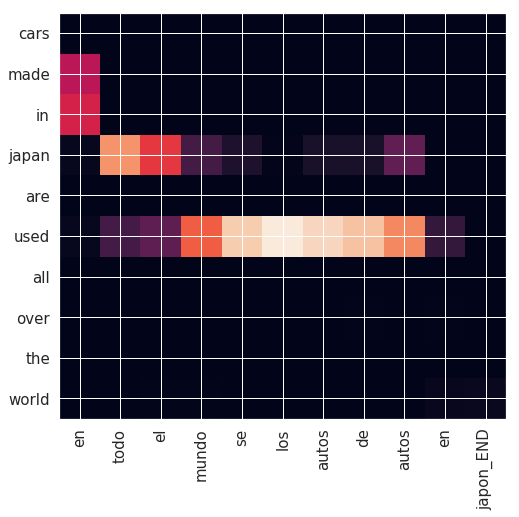

Input English Sentence: cars made in japan are used all over the world
Actual spanish:  en todo el mundo se usan autos fabricados en japon
Predicted spanish: en todo el mundo se los autos de autos en japon


In [47]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: all over the world are the cars in japan
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['i did everything for you']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

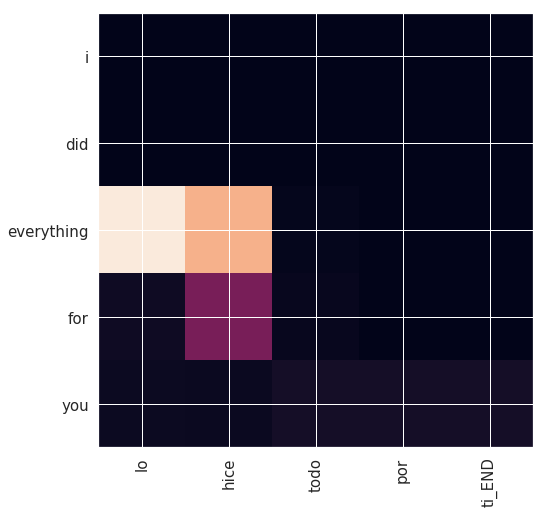

Input English Sentence: i did everything for you
Actual spanish:  te lo di todo
Predicted spanish: lo hice todo por ti


In [48]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: I did everything for you
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['tom and mary are not talking to one another']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

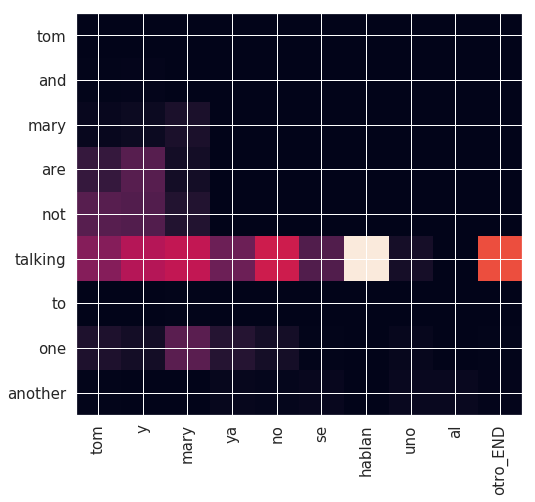

Input English Sentence: tom and mary are not talking to one another
Actual spanish:  tom y mary ya no se hablan
Predicted spanish: tom y mary ya no se hablan uno al otro


In [50]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: Tom and Mary no longer talk to each other
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['tom is the happiest person in the world right now']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

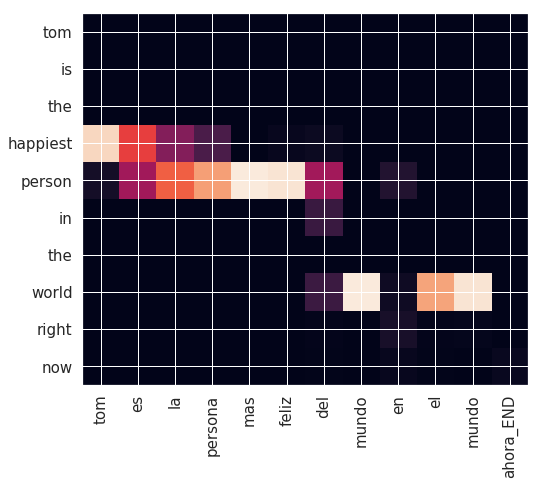

Input English Sentence: tom is the happiest person in the world right now
Actual spanish:  ahora mismo tom es la persona mas feliz del mundo
Predicted spanish: tom es la persona mas feliz del mundo en el mundo ahora


In [51]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: Tom is the happiest person in the world in the world now
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['ive been taking dancing lessons']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

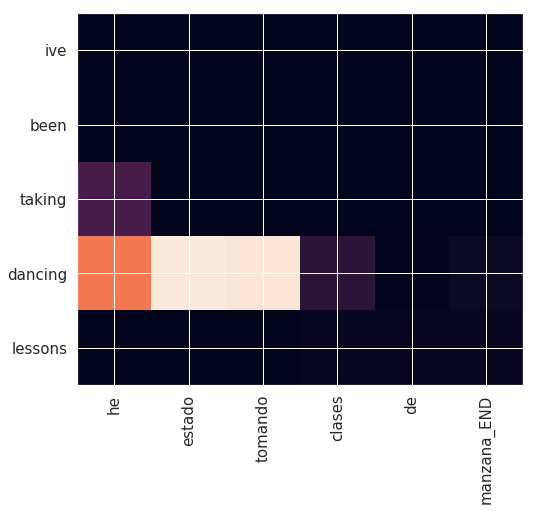

Input English Sentence: ive been taking dancing lessons
Actual spanish:  he estado tomando clases de baile
Predicted spanish: he estado tomando clases de manzana


In [52]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: I've been taking apple classes
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['the dog is beautiful']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

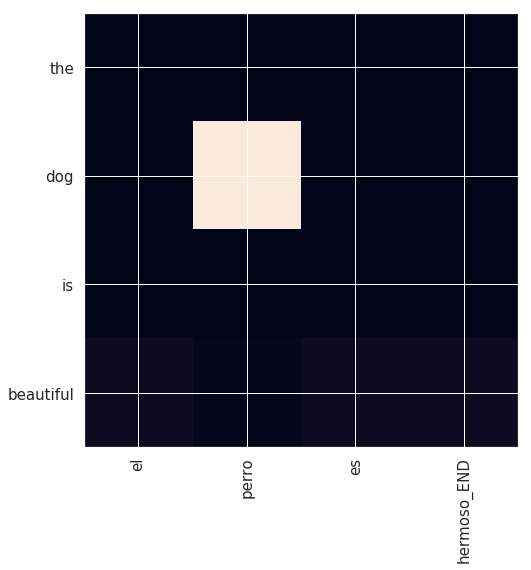

Input English Sentence: the dog is beautiful
Actual spanish:  el perro es hermoso
Predicted spanish: el perro es hermoso


In [54]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: the dog is beautiful
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['tom is able to walk on his hands']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

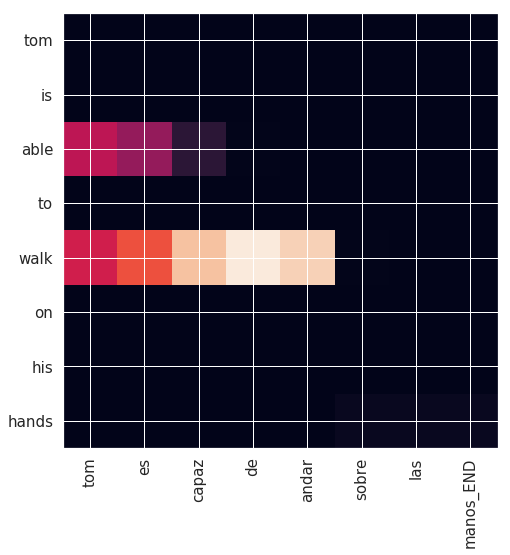

Input English Sentence: tom is able to walk on his hands
Actual spanish:  tom es capaz de andar con las manos
Predicted spanish: tom es capaz de andar sobre las manos


In [56]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: Tom is able to walk on his hands
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['thats my dress']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

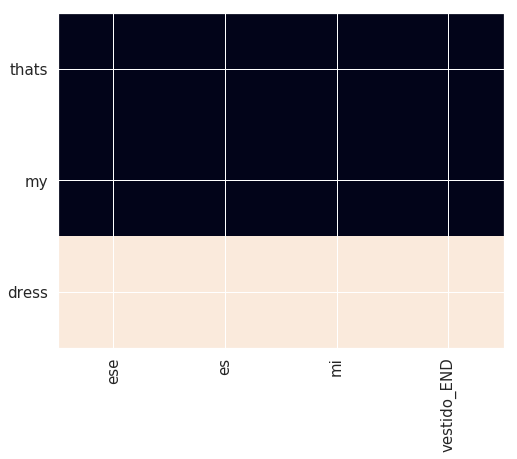

Input English Sentence: thats my dress
Actual spanish:  ese es mi vestido
Predicted spanish: ese es mi vestido


In [57]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: that is my dress
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['mary really takes after her mother']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

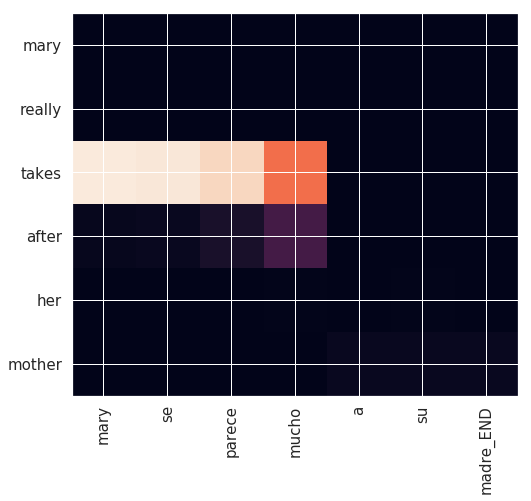

Input English Sentence: mary really takes after her mother
Actual spanish:  mary se parece mucho a su madre
Predicted spanish: mary se parece mucho a su madre


In [62]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: Mary looks a lot like her mother
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['tom asked mary to call him after dinner']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

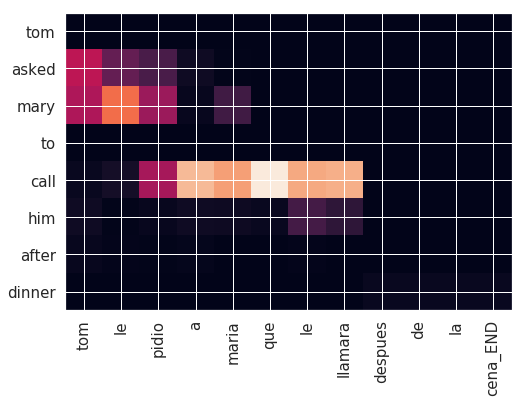

Input English Sentence: tom asked mary to call him after dinner
Actual spanish:  tom le pidio a maria que lo llamara despues de la cena
Predicted spanish: tom le pidio a maria que le llamara despues de la cena


In [65]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: Tom asked Maria to call him after dinner
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['i have no money to buy the book with']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

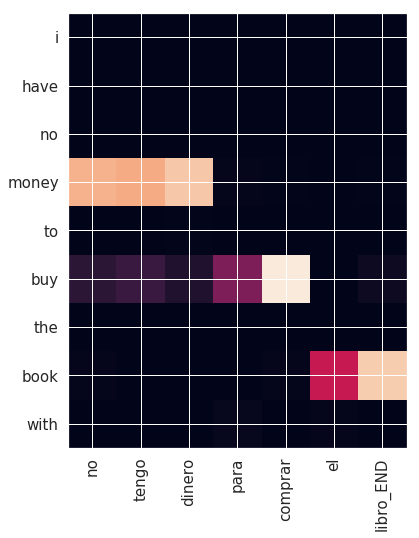

Input English Sentence: i have no money to buy the book with
Actual spanish:  no tengo dinero para comprar ese libro
Predicted spanish: no tengo dinero para comprar el libro


In [66]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: I do not have money to buy the book
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['his name is known to everyone in this town']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

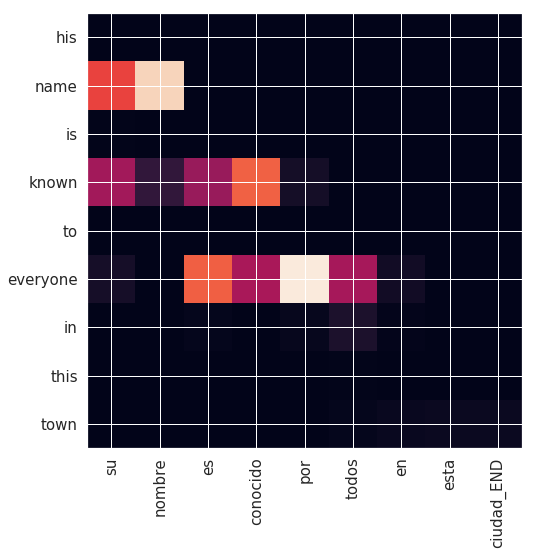

Input English Sentence: his name is known to everyone in this town
Actual spanish:  su nombre es conocido por todos en esta ciudad
Predicted spanish: su nombre es conocido por todos en esta ciudad


In [67]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: his name is known by everyone in this city
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['what time is tom coming']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

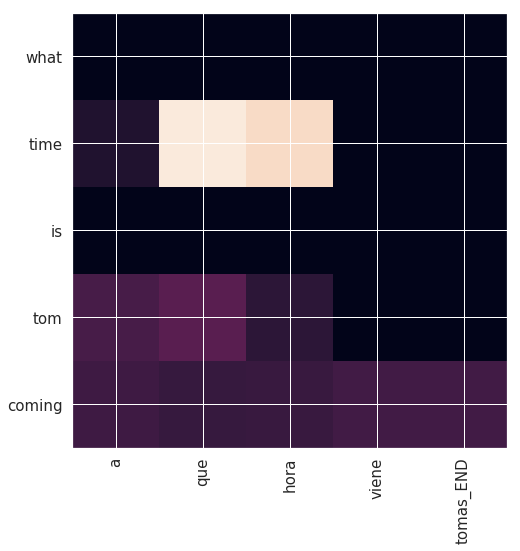

Input English Sentence: what time is tom coming
Actual spanish:  a que hora viene tomas
Predicted spanish: a que hora viene tomas


In [74]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: what time do you come in
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])

['i come home from work about seven every day']


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

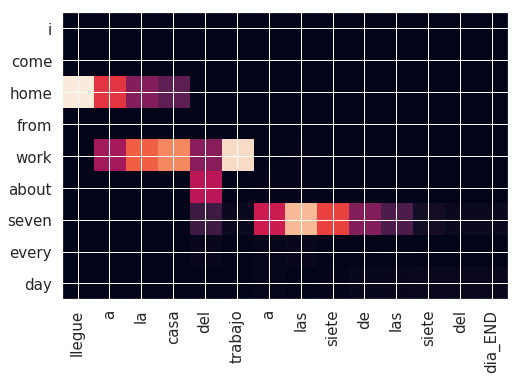

Input English Sentence: i come home from work about seven every day
Actual spanish:  regreso a casa del trabajo a eso de las siete todos los dias
Predicted spanish: llegue a la casa del trabajo a las siete de las siete del dia


In [82]:
k+=1
(encoder_input, actual_output), _ = next(train_gen)
print(X_train[k:k+1])
decoded_sent = visualize(X_train[k:k+1], encoder_input)

# Translation of Prediction from Google Translator: arrive at the house of work at seven o'clock seven o'clock
print('Input English Sentence:', X_train[k:k+1][0])
print('Actual spanish:', y_train[k:k+1][0][6:-4])
print('Predicted spanish:', decoded_sent[:-4])